In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
cap = cv2.VideoCapture('Run.avi')
num_frames=0
ret=True
while(ret==True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    num_frames=num_frames+1
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #frame.shape
        
print(num_frames)

57


In [39]:
cap = cv2.VideoCapture('Run.avi')
ret,frame=cap.read()
frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])


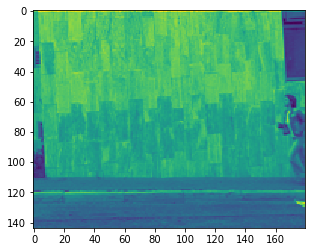

In [40]:
plt.imshow(frame)


In [41]:
np.min(frame)


10.288

In [42]:
shape = frame.shape

In [43]:
shape

(144, 180)

In [44]:
type(frame)

numpy.ndarray

In [45]:
frame

array([[161.428, 163.411, 157.422, ..., 103.518,  99.404,  97.632],
       [128.069, 133.052, 128.65 , ...,  67.29 ,  65.877,  64.404],
       [135.482, 134.052, 130.764, ...,  69.877,  65.29 ,  61.404],
       ...,
       [ 69.88 ,  70.706,  65.82 , ...,  80.244,  76.244,  72.244],
       [ 76.005,  68.532,  66.119, ...,  68.244,  69.532,  63.646],
       [ 78.364,  72.005,  72.005, ...,  65.244,  69.532,  70.347]])

In [46]:
K=4

In [47]:
parameters = np.zeros((shape[0],shape[1],K*2 + K))
alpha = 0.001 #To update weight 
#K gaussians, 1 parameter for sigma, 1 for mu for each of the gaussians and 4 parameters for the weights

In [48]:
import numpy.matlib as nlib
parameters[:,:,8:12]=1/K #Setting initial weights
frame = frame/255.0 #Normalise 1st frame
parameters[:,:,0]=0.0784#20#Standard deviation is one
parameters[:,:,2]=0.0784#20
parameters[:,:,4]=0.0784#20
parameters[:,:,6]=0.0784#20#Standard deviation is one for first frame
parameters[:,:,1]=0.6549#167.379#frame#Mean value is just pixel value for first frame
parameters[:,:,3]=0.615#157#frame
parameters[:,:,5]=0.694#177#frame
parameters[:,:,7]=0.627#160#frame

In [49]:
#Gaussian function
def Gaussian(mu,sigmasquare,x):
    #mu and x are 1*1
    #a = np.transpose(x-mu)
    #siginv = (1/sigmasquare)*np.array([[1,0,0],[0,1,0],[0,0,1]])
    #b = np.matmul(a,siginv)
    #b = np.matmul(b,x-mu)
    b = (x-mu)*(x-mu)
    b = b*(-1/2)
    b = b/sigmasquare
    b = np.exp(b)
    b = b/np.power(2*22/7,0.5)
    sigma = np.sqrt(sigmasquare)
    b = b/(sigma)
    fg=0
    if(x>mu+2.5*sigma):
        fg=1
    if(x<mu-2.5*sigma):
        fg=1
    b = alpha*b
    return b,fg

1
2
3
4
5
6
7
8
9


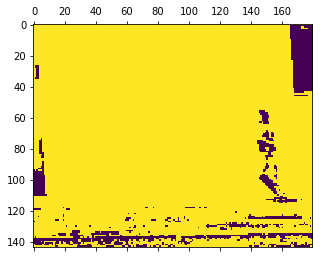

In [50]:
#Parameter updation and backgroud detection using rest of the frames
k=0
#while(ret==True):
while(k<=8):
    ret, frame = cap.read()
    frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
    frame = frame/255.0
    k=k+1
    foreground = np.zeros((shape[0],shape[1]))#Full black
    print(k)
    for i in range(shape[0]):
        for j in range(shape[1]):
            #Getting details of current frame with past parameters
            ro1,fg1 = Gaussian(np.transpose(parameters[i,j,1]),parameters[i,j,0],np.transpose(frame[i,j]))
            ro2,fg2 = Gaussian(np.transpose(parameters[i,j,3]),parameters[i,j,2],np.transpose(frame[i,j]))
            ro3,fg3 = Gaussian(np.transpose(parameters[i,j,5]),parameters[i,j,4],np.transpose(frame[i,j]))
            ro4,fg4 = Gaussian(np.transpose(parameters[i,j,7]),parameters[i,j,6],np.transpose(frame[i,j]))
            prob = parameters[i,j,8]*ro1+parameters[i,j,9]*ro2+parameters[i,j,10]*ro3+parameters[i,j,11]*ro4
            prob = prob/alpha
            if(prob>0.6):
                foreground[i,j]=1
            #Updating weights
            if(fg1>=2):
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]+(alpha)
            else:
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]
            if(fg2>=2):
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]+(alpha)
            else:
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]
            if(fg3>=2):
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]+(alpha)
            else:
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]
            if(fg4>=2):
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]+(alpha)
            else:
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]
            #Updating mu
            parameters[i,j,1] = (1-ro1)*parameters[i,j,1] + ro1*frame[i,j]
            parameters[i,j,3] = (1-ro2)*parameters[i,j,3] + ro2*frame[i,j]
            parameters[i,j,5] = (1-ro3)*parameters[i,j,5] + ro3*frame[i,j]
            parameters[i,j,7] = (1-ro4)*parameters[i,j,7] + ro4*frame[i,j]
            #Updating sigma
            parameters[i,j,0] = (1-ro1)*parameters[i,j,0] + ro1*(frame[i,j]-parameters[i,j,1])*(frame[i,j]-parameters[i,j,1])
            parameters[i,j,2] = (1-ro2)*parameters[i,j,2] + ro2*(frame[i,j]-parameters[i,j,3])*(frame[i,j]-parameters[i,j,3])
            parameters[i,j,4] = (1-ro3)*parameters[i,j,4] + ro3*(frame[i,j]-parameters[i,j,5])*(frame[i,j]-parameters[i,j,5])
            parameters[i,j,6] = (1-ro4)*parameters[i,j,6] + ro4*(frame[i,j]-parameters[i,j,7])*(frame[i,j]-parameters[i,j,7])
            #if(k%10==0):
            #    plt.matshow(foreground)
plt.matshow(foreground)            

10
11
12
13
14
15


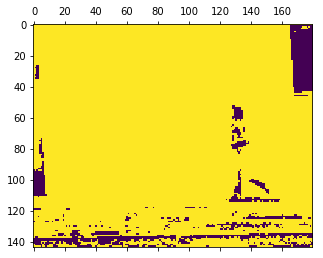

In [51]:
#Parameter updation and backgroud detection using rest of the frames
k=9
#while(ret==True):
while(k<=14):
    ret, frame = cap.read()
    frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
    frame = frame/255.0
    k=k+1
    foreground = np.zeros((shape[0],shape[1]))#Full black
    print(k)
    for i in range(shape[0]):
        for j in range(shape[1]):
            #Getting details of current frame with past parameters
            ro1,fg1 = Gaussian(np.transpose(parameters[i,j,1]),parameters[i,j,0],np.transpose(frame[i,j]))
            ro2,fg2 = Gaussian(np.transpose(parameters[i,j,3]),parameters[i,j,2],np.transpose(frame[i,j]))
            ro3,fg3 = Gaussian(np.transpose(parameters[i,j,5]),parameters[i,j,4],np.transpose(frame[i,j]))
            ro4,fg4 = Gaussian(np.transpose(parameters[i,j,7]),parameters[i,j,6],np.transpose(frame[i,j]))
            prob = parameters[i,j,8]*ro1+parameters[i,j,9]*ro2+parameters[i,j,10]*ro3+parameters[i,j,11]*ro4
            prob = prob/alpha
            if(prob>0.6):
                foreground[i,j]=1
            #Updating weights
            if(fg1>=2):
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]+(alpha)
            else:
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]
            if(fg2>=2):
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]+(alpha)
            else:
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]
            if(fg3>=2):
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]+(alpha)
            else:
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]
            if(fg4>=2):
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]+(alpha)
            else:
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]
            #Updating mu
            parameters[i,j,1] = (1-ro1)*parameters[i,j,1] + ro1*frame[i,j]
            parameters[i,j,3] = (1-ro2)*parameters[i,j,3] + ro2*frame[i,j]
            parameters[i,j,5] = (1-ro3)*parameters[i,j,5] + ro3*frame[i,j]
            parameters[i,j,7] = (1-ro4)*parameters[i,j,7] + ro4*frame[i,j]
            #Updating sigma
            parameters[i,j,0] = (1-ro1)*parameters[i,j,0] + ro1*(frame[i,j]-parameters[i,j,1])*(frame[i,j]-parameters[i,j,1])
            parameters[i,j,2] = (1-ro2)*parameters[i,j,2] + ro2*(frame[i,j]-parameters[i,j,3])*(frame[i,j]-parameters[i,j,3])
            parameters[i,j,4] = (1-ro3)*parameters[i,j,4] + ro3*(frame[i,j]-parameters[i,j,5])*(frame[i,j]-parameters[i,j,5])
            parameters[i,j,6] = (1-ro4)*parameters[i,j,6] + ro4*(frame[i,j]-parameters[i,j,7])*(frame[i,j]-parameters[i,j,7])
            #if(k%10==0):
            #    plt.matshow(foreground)
plt.matshow(foreground)            

16
17
18
19
20
21


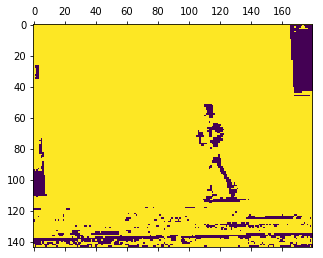

In [52]:
#Parameter updation and backgroud detection using rest of the frames
k=15
#while(ret==True):
while(k<=20):
    ret, frame = cap.read()
    frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
    frame = frame/255.0
    k=k+1
    foreground = np.zeros((shape[0],shape[1]))#Full black
    print(k)
    for i in range(shape[0]):
        for j in range(shape[1]):
            #Getting details of current frame with past parameters
            ro1,fg1 = Gaussian(np.transpose(parameters[i,j,1]),parameters[i,j,0],np.transpose(frame[i,j]))
            ro2,fg2 = Gaussian(np.transpose(parameters[i,j,3]),parameters[i,j,2],np.transpose(frame[i,j]))
            ro3,fg3 = Gaussian(np.transpose(parameters[i,j,5]),parameters[i,j,4],np.transpose(frame[i,j]))
            ro4,fg4 = Gaussian(np.transpose(parameters[i,j,7]),parameters[i,j,6],np.transpose(frame[i,j]))
            prob = parameters[i,j,8]*ro1+parameters[i,j,9]*ro2+parameters[i,j,10]*ro3+parameters[i,j,11]*ro4
            prob = prob/alpha
            if(prob>0.6):
                foreground[i,j]=1
            #Updating weights
            if(fg1>=2):
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]+(alpha)
            else:
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]
            if(fg2>=2):
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]+(alpha)
            else:
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]
            if(fg3>=2):
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]+(alpha)
            else:
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]
            if(fg4>=2):
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]+(alpha)
            else:
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]
            #Updating mu
            parameters[i,j,1] = (1-ro1)*parameters[i,j,1] + ro1*frame[i,j]
            parameters[i,j,3] = (1-ro2)*parameters[i,j,3] + ro2*frame[i,j]
            parameters[i,j,5] = (1-ro3)*parameters[i,j,5] + ro3*frame[i,j]
            parameters[i,j,7] = (1-ro4)*parameters[i,j,7] + ro4*frame[i,j]
            #Updating sigma
            parameters[i,j,0] = (1-ro1)*parameters[i,j,0] + ro1*(frame[i,j]-parameters[i,j,1])*(frame[i,j]-parameters[i,j,1])
            parameters[i,j,2] = (1-ro2)*parameters[i,j,2] + ro2*(frame[i,j]-parameters[i,j,3])*(frame[i,j]-parameters[i,j,3])
            parameters[i,j,4] = (1-ro3)*parameters[i,j,4] + ro3*(frame[i,j]-parameters[i,j,5])*(frame[i,j]-parameters[i,j,5])
            parameters[i,j,6] = (1-ro4)*parameters[i,j,6] + ro4*(frame[i,j]-parameters[i,j,7])*(frame[i,j]-parameters[i,j,7])
            #if(k%10==0):
            #    plt.matshow(foreground)
plt.matshow(foreground)            

22
23
24
25
26
27
28


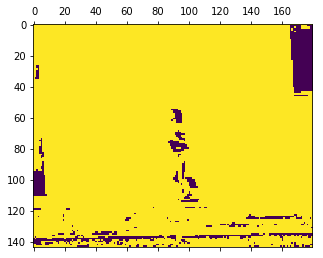

In [53]:
#Parameter updation and backgroud detection using rest of the frames
k=21
#while(ret==True):
while(k<=27):
    ret, frame = cap.read()
    frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
    frame = frame/255.0
    k=k+1
    foreground = np.zeros((shape[0],shape[1]))#Full black
    print(k)
    for i in range(shape[0]):
        for j in range(shape[1]):
            #Getting details of current frame with past parameters
            ro1,fg1 = Gaussian(np.transpose(parameters[i,j,1]),parameters[i,j,0],np.transpose(frame[i,j]))
            ro2,fg2 = Gaussian(np.transpose(parameters[i,j,3]),parameters[i,j,2],np.transpose(frame[i,j]))
            ro3,fg3 = Gaussian(np.transpose(parameters[i,j,5]),parameters[i,j,4],np.transpose(frame[i,j]))
            ro4,fg4 = Gaussian(np.transpose(parameters[i,j,7]),parameters[i,j,6],np.transpose(frame[i,j]))
            prob = parameters[i,j,8]*ro1+parameters[i,j,9]*ro2+parameters[i,j,10]*ro3+parameters[i,j,11]*ro4
            prob = prob/alpha
            if(prob>0.6):
                foreground[i,j]=1
            #Updating weights
            if(fg1>=2):
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]+(alpha)
            else:
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]
            if(fg2>=2):
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]+(alpha)
            else:
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]
            if(fg3>=2):
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]+(alpha)
            else:
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]
            if(fg4>=2):
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]+(alpha)
            else:
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]
            #Updating mu
            parameters[i,j,1] = (1-ro1)*parameters[i,j,1] + ro1*frame[i,j]
            parameters[i,j,3] = (1-ro2)*parameters[i,j,3] + ro2*frame[i,j]
            parameters[i,j,5] = (1-ro3)*parameters[i,j,5] + ro3*frame[i,j]
            parameters[i,j,7] = (1-ro4)*parameters[i,j,7] + ro4*frame[i,j]
            #Updating sigma
            parameters[i,j,0] = (1-ro1)*parameters[i,j,0] + ro1*(frame[i,j]-parameters[i,j,1])*(frame[i,j]-parameters[i,j,1])
            parameters[i,j,2] = (1-ro2)*parameters[i,j,2] + ro2*(frame[i,j]-parameters[i,j,3])*(frame[i,j]-parameters[i,j,3])
            parameters[i,j,4] = (1-ro3)*parameters[i,j,4] + ro3*(frame[i,j]-parameters[i,j,5])*(frame[i,j]-parameters[i,j,5])
            parameters[i,j,6] = (1-ro4)*parameters[i,j,6] + ro4*(frame[i,j]-parameters[i,j,7])*(frame[i,j]-parameters[i,j,7])
            #if(k%10==0):
            #    plt.matshow(foreground)
plt.matshow(foreground)            

29
30
31
32
33
34
35


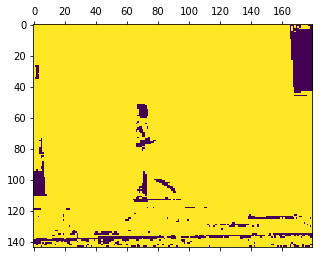

In [54]:
#Parameter updation and backgroud detection using rest of the frames
k=28
#while(ret==True):
while(k<=34):
    ret, frame = cap.read()
    frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
    frame = frame/255.0
    k=k+1
    foreground = np.zeros((shape[0],shape[1]))#Full black
    print(k)
    for i in range(shape[0]):
        for j in range(shape[1]):
            #Getting details of current frame with past parameters
            ro1,fg1 = Gaussian(np.transpose(parameters[i,j,1]),parameters[i,j,0],np.transpose(frame[i,j]))
            ro2,fg2 = Gaussian(np.transpose(parameters[i,j,3]),parameters[i,j,2],np.transpose(frame[i,j]))
            ro3,fg3 = Gaussian(np.transpose(parameters[i,j,5]),parameters[i,j,4],np.transpose(frame[i,j]))
            ro4,fg4 = Gaussian(np.transpose(parameters[i,j,7]),parameters[i,j,6],np.transpose(frame[i,j]))
            prob = parameters[i,j,8]*ro1+parameters[i,j,9]*ro2+parameters[i,j,10]*ro3+parameters[i,j,11]*ro4
            prob = prob/alpha
            if(prob>0.6):
                foreground[i,j]=1
            #Updating weights
            if(fg1>=2):
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]+(alpha)
            else:
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]
            if(fg2>=2):
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]+(alpha)
            else:
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]
            if(fg3>=2):
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]+(alpha)
            else:
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]
            if(fg4>=2):
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]+(alpha)
            else:
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]
            #Updating mu
            parameters[i,j,1] = (1-ro1)*parameters[i,j,1] + ro1*frame[i,j]
            parameters[i,j,3] = (1-ro2)*parameters[i,j,3] + ro2*frame[i,j]
            parameters[i,j,5] = (1-ro3)*parameters[i,j,5] + ro3*frame[i,j]
            parameters[i,j,7] = (1-ro4)*parameters[i,j,7] + ro4*frame[i,j]
            #Updating sigma
            parameters[i,j,0] = (1-ro1)*parameters[i,j,0] + ro1*(frame[i,j]-parameters[i,j,1])*(frame[i,j]-parameters[i,j,1])
            parameters[i,j,2] = (1-ro2)*parameters[i,j,2] + ro2*(frame[i,j]-parameters[i,j,3])*(frame[i,j]-parameters[i,j,3])
            parameters[i,j,4] = (1-ro3)*parameters[i,j,4] + ro3*(frame[i,j]-parameters[i,j,5])*(frame[i,j]-parameters[i,j,5])
            parameters[i,j,6] = (1-ro4)*parameters[i,j,6] + ro4*(frame[i,j]-parameters[i,j,7])*(frame[i,j]-parameters[i,j,7])
            #if(k%10==0):
            #    plt.matshow(foreground)
plt.matshow(foreground)            

36
37
38
39
40
41


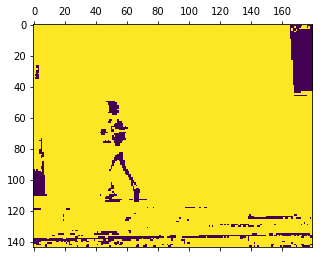

In [55]:
#Parameter updation and backgroud detection using rest of the frames
k=35
#while(ret==True):
while(k<=40):
    ret, frame = cap.read()
    frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
    frame = frame/255.0
    k=k+1
    foreground = np.zeros((shape[0],shape[1]))#Full black
    print(k)
    for i in range(shape[0]):
        for j in range(shape[1]):
            #Getting details of current frame with past parameters
            ro1,fg1 = Gaussian(np.transpose(parameters[i,j,1]),parameters[i,j,0],np.transpose(frame[i,j]))
            ro2,fg2 = Gaussian(np.transpose(parameters[i,j,3]),parameters[i,j,2],np.transpose(frame[i,j]))
            ro3,fg3 = Gaussian(np.transpose(parameters[i,j,5]),parameters[i,j,4],np.transpose(frame[i,j]))
            ro4,fg4 = Gaussian(np.transpose(parameters[i,j,7]),parameters[i,j,6],np.transpose(frame[i,j]))
            prob = parameters[i,j,8]*ro1+parameters[i,j,9]*ro2+parameters[i,j,10]*ro3+parameters[i,j,11]*ro4
            prob = prob/alpha
            if(prob>0.6):
                foreground[i,j]=1
            #Updating weights
            if(fg1>=2):
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]+(alpha)
            else:
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]
            if(fg2>=2):
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]+(alpha)
            else:
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]
            if(fg3>=2):
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]+(alpha)
            else:
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]
            if(fg4>=2):
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]+(alpha)
            else:
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]
            #Updating mu
            parameters[i,j,1] = (1-ro1)*parameters[i,j,1] + ro1*frame[i,j]
            parameters[i,j,3] = (1-ro2)*parameters[i,j,3] + ro2*frame[i,j]
            parameters[i,j,5] = (1-ro3)*parameters[i,j,5] + ro3*frame[i,j]
            parameters[i,j,7] = (1-ro4)*parameters[i,j,7] + ro4*frame[i,j]
            #Updating sigma
            parameters[i,j,0] = (1-ro1)*parameters[i,j,0] + ro1*(frame[i,j]-parameters[i,j,1])*(frame[i,j]-parameters[i,j,1])
            parameters[i,j,2] = (1-ro2)*parameters[i,j,2] + ro2*(frame[i,j]-parameters[i,j,3])*(frame[i,j]-parameters[i,j,3])
            parameters[i,j,4] = (1-ro3)*parameters[i,j,4] + ro3*(frame[i,j]-parameters[i,j,5])*(frame[i,j]-parameters[i,j,5])
            parameters[i,j,6] = (1-ro4)*parameters[i,j,6] + ro4*(frame[i,j]-parameters[i,j,7])*(frame[i,j]-parameters[i,j,7])
            #if(k%10==0):
            #    plt.matshow(foreground)
plt.matshow(foreground)            

42
43
44
45
46
47


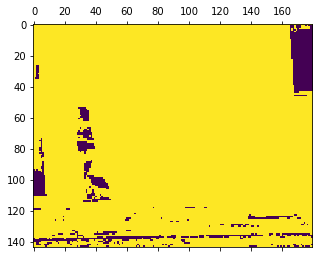

In [56]:
#Parameter updation and backgroud detection using rest of the frames
k=41
#while(ret==True):
while(k<=46):
    ret, frame = cap.read()
    frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
    frame = frame/255.0
    k=k+1
    foreground = np.zeros((shape[0],shape[1]))#Full black
    print(k)
    for i in range(shape[0]):
        for j in range(shape[1]):
            #Getting details of current frame with past parameters
            ro1,fg1 = Gaussian(np.transpose(parameters[i,j,1]),parameters[i,j,0],np.transpose(frame[i,j]))
            ro2,fg2 = Gaussian(np.transpose(parameters[i,j,3]),parameters[i,j,2],np.transpose(frame[i,j]))
            ro3,fg3 = Gaussian(np.transpose(parameters[i,j,5]),parameters[i,j,4],np.transpose(frame[i,j]))
            ro4,fg4 = Gaussian(np.transpose(parameters[i,j,7]),parameters[i,j,6],np.transpose(frame[i,j]))
            prob = parameters[i,j,8]*ro1+parameters[i,j,9]*ro2+parameters[i,j,10]*ro3+parameters[i,j,11]*ro4
            prob = prob/alpha
            if(prob>0.6):
                foreground[i,j]=1
            #Updating weights
            if(fg1>=2):
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]+(alpha)
            else:
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]
            if(fg2>=2):
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]+(alpha)
            else:
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]
            if(fg3>=2):
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]+(alpha)
            else:
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]
            if(fg4>=2):
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]+(alpha)
            else:
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]
            #Updating mu
            parameters[i,j,1] = (1-ro1)*parameters[i,j,1] + ro1*frame[i,j]
            parameters[i,j,3] = (1-ro2)*parameters[i,j,3] + ro2*frame[i,j]
            parameters[i,j,5] = (1-ro3)*parameters[i,j,5] + ro3*frame[i,j]
            parameters[i,j,7] = (1-ro4)*parameters[i,j,7] + ro4*frame[i,j]
            #Updating sigma
            parameters[i,j,0] = (1-ro1)*parameters[i,j,0] + ro1*(frame[i,j]-parameters[i,j,1])*(frame[i,j]-parameters[i,j,1])
            parameters[i,j,2] = (1-ro2)*parameters[i,j,2] + ro2*(frame[i,j]-parameters[i,j,3])*(frame[i,j]-parameters[i,j,3])
            parameters[i,j,4] = (1-ro3)*parameters[i,j,4] + ro3*(frame[i,j]-parameters[i,j,5])*(frame[i,j]-parameters[i,j,5])
            parameters[i,j,6] = (1-ro4)*parameters[i,j,6] + ro4*(frame[i,j]-parameters[i,j,7])*(frame[i,j]-parameters[i,j,7])
            #if(k%10==0):
            #    plt.matshow(foreground)
plt.matshow(foreground)            

48
49
50
51


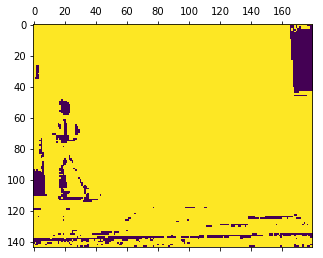

In [57]:
#Parameter updation and backgroud detection using rest of the frames
k=47
#while(ret==True):
while(k<=50):
    ret, frame = cap.read()
    frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
    frame = frame/255.0
    k=k+1
    foreground = np.zeros((shape[0],shape[1]))#Full black
    print(k)
    for i in range(shape[0]):
        for j in range(shape[1]):
            #Getting details of current frame with past parameters
            ro1,fg1 = Gaussian(np.transpose(parameters[i,j,1]),parameters[i,j,0],np.transpose(frame[i,j]))
            ro2,fg2 = Gaussian(np.transpose(parameters[i,j,3]),parameters[i,j,2],np.transpose(frame[i,j]))
            ro3,fg3 = Gaussian(np.transpose(parameters[i,j,5]),parameters[i,j,4],np.transpose(frame[i,j]))
            ro4,fg4 = Gaussian(np.transpose(parameters[i,j,7]),parameters[i,j,6],np.transpose(frame[i,j]))
            prob = parameters[i,j,8]*ro1+parameters[i,j,9]*ro2+parameters[i,j,10]*ro3+parameters[i,j,11]*ro4
            prob = prob/alpha
            if(prob>0.6):
                foreground[i,j]=1
            #Updating weights
            if(fg1>=2):
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]+(alpha)
            else:
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]
            if(fg2>=2):
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]+(alpha)
            else:
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]
            if(fg3>=2):
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]+(alpha)
            else:
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]
            if(fg4>=2):
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]+(alpha)
            else:
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]
            #Updating mu
            parameters[i,j,1] = (1-ro1)*parameters[i,j,1] + ro1*frame[i,j]
            parameters[i,j,3] = (1-ro2)*parameters[i,j,3] + ro2*frame[i,j]
            parameters[i,j,5] = (1-ro3)*parameters[i,j,5] + ro3*frame[i,j]
            parameters[i,j,7] = (1-ro4)*parameters[i,j,7] + ro4*frame[i,j]
            #Updating sigma
            parameters[i,j,0] = (1-ro1)*parameters[i,j,0] + ro1*(frame[i,j]-parameters[i,j,1])*(frame[i,j]-parameters[i,j,1])
            parameters[i,j,2] = (1-ro2)*parameters[i,j,2] + ro2*(frame[i,j]-parameters[i,j,3])*(frame[i,j]-parameters[i,j,3])
            parameters[i,j,4] = (1-ro3)*parameters[i,j,4] + ro3*(frame[i,j]-parameters[i,j,5])*(frame[i,j]-parameters[i,j,5])
            parameters[i,j,6] = (1-ro4)*parameters[i,j,6] + ro4*(frame[i,j]-parameters[i,j,7])*(frame[i,j]-parameters[i,j,7])
            #if(k%10==0):
            #    plt.matshow(foreground)
plt.matshow(foreground)            

52
53
54
55


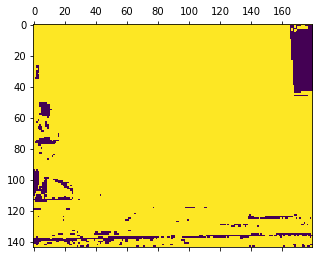

In [58]:
#Parameter updation and backgroud detection using rest of the frames
k=51
#while(ret==True):
while(k<=54):
    ret, frame = cap.read()
    frame = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
    frame = frame/255.0
    k=k+1
    foreground = np.zeros((shape[0],shape[1]))#Full black
    print(k)
    for i in range(shape[0]):
        for j in range(shape[1]):
            #Getting details of current frame with past parameters
            ro1,fg1 = Gaussian(np.transpose(parameters[i,j,1]),parameters[i,j,0],np.transpose(frame[i,j]))
            ro2,fg2 = Gaussian(np.transpose(parameters[i,j,3]),parameters[i,j,2],np.transpose(frame[i,j]))
            ro3,fg3 = Gaussian(np.transpose(parameters[i,j,5]),parameters[i,j,4],np.transpose(frame[i,j]))
            ro4,fg4 = Gaussian(np.transpose(parameters[i,j,7]),parameters[i,j,6],np.transpose(frame[i,j]))
            prob = parameters[i,j,8]*ro1+parameters[i,j,9]*ro2+parameters[i,j,10]*ro3+parameters[i,j,11]*ro4
            prob = prob/alpha
            if(prob>0.6):
                foreground[i,j]=1
            #Updating weights
            if(fg1>=2):
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]+(alpha)
            else:
                parameters[i,j,8] = (1-alpha)*parameters[i,j,8]
            if(fg2>=2):
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]+(alpha)
            else:
                parameters[i,j,9] = (1-alpha)*parameters[i,j,9]
            if(fg3>=2):
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]+(alpha)
            else:
                parameters[i,j,10] = (1-alpha)*parameters[i,j,10]
            if(fg4>=2):
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]+(alpha)
            else:
                parameters[i,j,11] = (1-alpha)*parameters[i,j,11]
            #Updating mu
            parameters[i,j,1] = (1-ro1)*parameters[i,j,1] + ro1*frame[i,j]
            parameters[i,j,3] = (1-ro2)*parameters[i,j,3] + ro2*frame[i,j]
            parameters[i,j,5] = (1-ro3)*parameters[i,j,5] + ro3*frame[i,j]
            parameters[i,j,7] = (1-ro4)*parameters[i,j,7] + ro4*frame[i,j]
            #Updating sigma
            parameters[i,j,0] = (1-ro1)*parameters[i,j,0] + ro1*(frame[i,j]-parameters[i,j,1])*(frame[i,j]-parameters[i,j,1])
            parameters[i,j,2] = (1-ro2)*parameters[i,j,2] + ro2*(frame[i,j]-parameters[i,j,3])*(frame[i,j]-parameters[i,j,3])
            parameters[i,j,4] = (1-ro3)*parameters[i,j,4] + ro3*(frame[i,j]-parameters[i,j,5])*(frame[i,j]-parameters[i,j,5])
            parameters[i,j,6] = (1-ro4)*parameters[i,j,6] + ro4*(frame[i,j]-parameters[i,j,7])*(frame[i,j]-parameters[i,j,7])
            #if(k%10==0):
            #    plt.matshow(foreground)
plt.matshow(foreground)            